# Perform EDA & Create Baseline Model 

## Load libraries & data

In [1]:
import numpy as np
import pandas as pd
import PIL
import os, glob

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc

import keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
all_data = pd.read_csv('../painting_data/kaggle_paint_numbers/csv/all_data_info.csv')
print('shape:', all_data.shape)
all_data.head()

shape: (103250, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


## Mask training data 
Motivation on using all data over training — I'd like to know artist name which is not available in training data.

In [3]:
train_paintings = all_data[all_data.in_train]
train_paintings.shape

(79433, 12)

## Mask testing data 

In [4]:
test_paintings = all_data[~all_data.in_train]
test_paintings.shape

(23817, 12)

In [64]:
train_paintings.shape[0] + test_paintings.shape[0]

103250

## Resize images
The painting training data is ~80,000 images ranging in size and aspect ratio. For example, one image on the larger end of the spectrum is 30000 × 29605 and on the smaller end, 283 × 558. I resized these all to be square, 72 x 72 for the purposes of machine learning as well as computation time. Resizing the images does cause a distortion and perhaps developing some method for cropping would be better, but for the sake of time, I think my resizing will suffice. 

**Below is the script I created to resize the images:**

In [5]:
! cat ../scripts/resize_script.py

import pandas as pd
from keras.preprocessing.image import load_img
from PIL import ImageFile

# ask PIL to be tolerant of files that are truncated
# ie, if image has missing data, it will be filled with gray
# suboptimal - would like to know which images are affected... also should've timed this
# https://stackoverflow.com/a/23575424
ImageFile.LOAD_TRUNCATED_IMAGES = True

# path to csv
csv_path = '../painting_data/kaggle_paint_numbers/csv/all_data_info.csv'
all_data = pd.read_csv(csv_path)

# subset only paintings in training set
train_paintings = all_data[all_data.in_train]


# file indices, names
num_files = range(train_paintings.shape[0])
filelist = train_paintings.index.values
filenames = train_paintings.new_filename

# source and destination directories
source_path = '../painting_data/kaggle_paint_numbers/paintings_train/'
dest_path = '../painting_data/kaggle_paint_numbers/resized_72/'

# loop over images and resize
for n, i, x in zip(num_files, filelist, filenames):
    train_im

## Display 1st 100 paintings

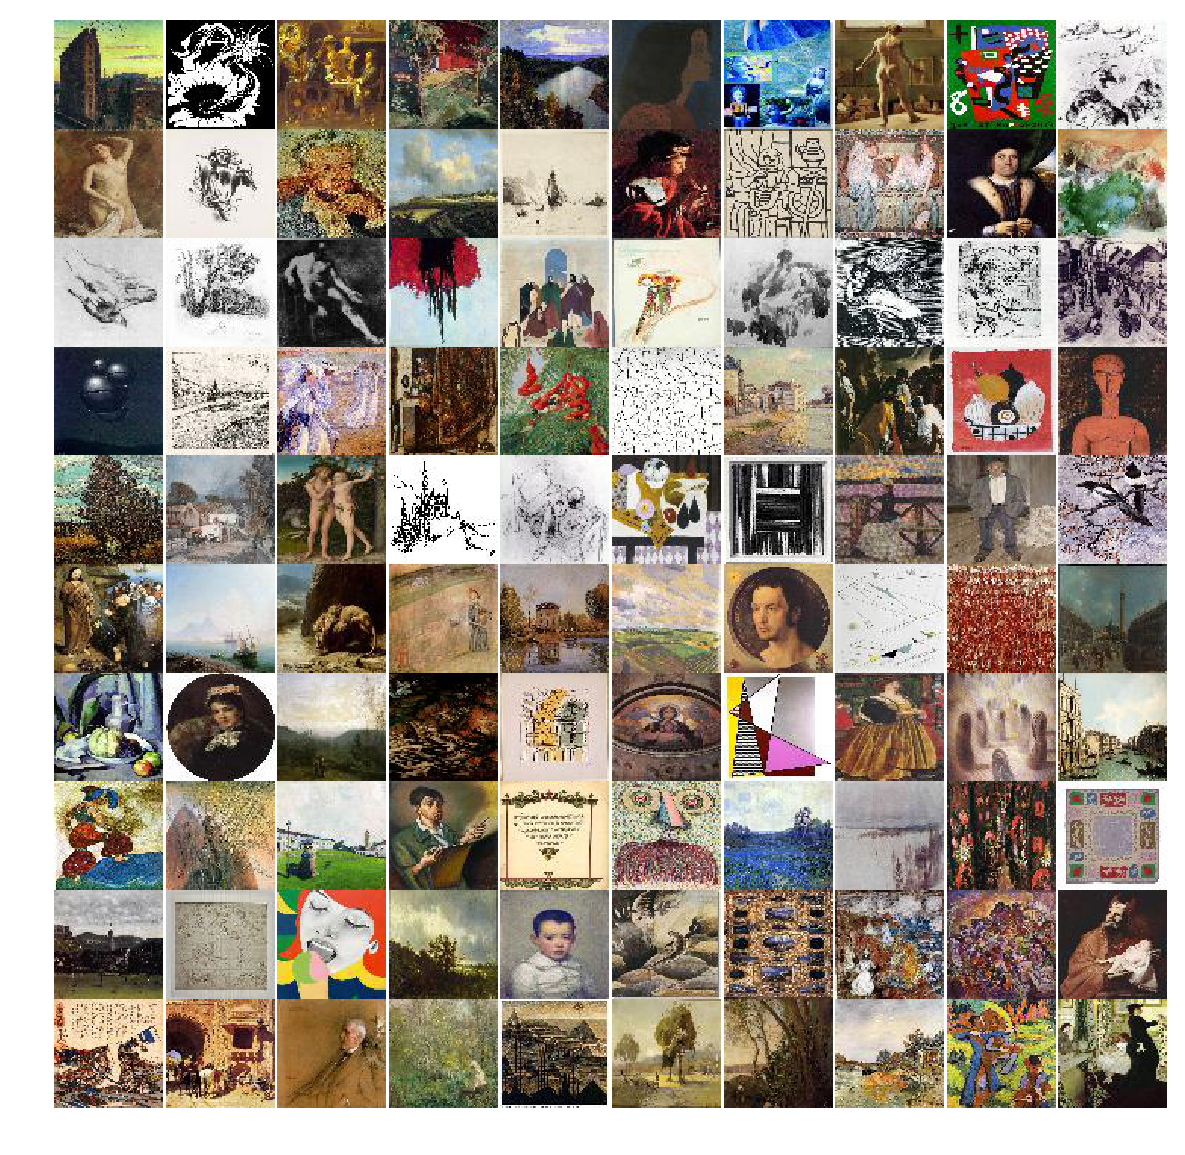

In [6]:
display_imgs = [f for f in glob.glob("../painting_data/kaggle_paint_numbers/resized_72_all/*")]

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)

for i, display_img in enumerate(display_imgs[:100]):
    img = load_img(display_img)
    plt.subplot(10, 10, i + 1) 
    plt.imshow(img); plt.axis('off')

## Paintings by Genre

In [8]:
print('Total number of unique painting genres:', train_paintings.genre.value_counts().shape[0])

# top 20 painting genres
train_paintings.genre.value_counts()[:20]

Total number of unique painting genres: 42


portrait                 12926
landscape                11548
genre painting           10984
abstract                  7201
religious painting        5703
cityscape                 4089
sketch and study          2778
illustration              2493
still life                2464
symbolic painting         1959
figurative                1782
nude painting (nu)        1758
design                    1577
mythological painting     1493
marina                    1385
flower painting           1270
animal painting           1233
self-portrait             1199
allegorical painting       809
history painting           656
Name: genre, dtype: int64

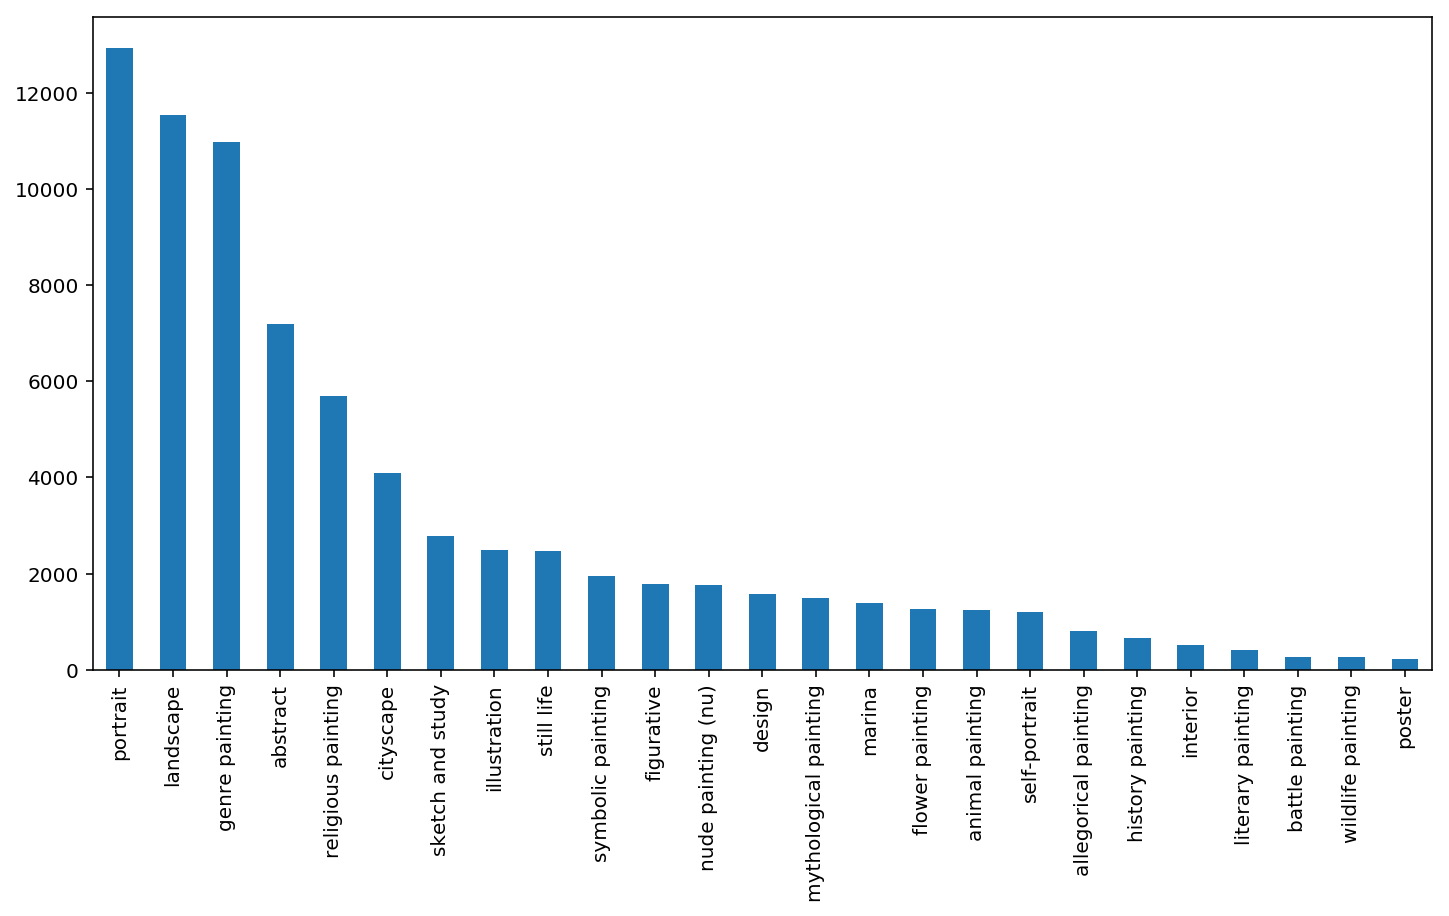

In [68]:
plt.subplots(figsize=(12, 6))
train_paintings.genre.value_counts().head(25).plot(kind='bar');

## Paintings by Style

In [12]:
print('Total number of unique painting styles:', train_paintings['style'].value_counts().shape[0])

# top 20 painting styles
train_paintings['style'].value_counts()[:20]

Total number of unique painting styles: 135


Impressionism                   8220
Realism                         8112
Romanticism                     7041
Expressionism                   5325
Post-Impressionism              4527
Art Nouveau (Modern)            3779
Baroque                         3254
Surrealism                      3133
Symbolism                       2626
Rococo                          2101
Northern Renaissance            1824
Naïve Art (Primitivism)         1776
Neoclassicism                   1622
Abstract Expressionism          1546
Cubism                          1316
Ukiyo-e                         1137
Early Renaissance               1052
High Renaissance                1050
Mannerism (Late Renaissance)    1025
Art Informel                     987
Name: style, dtype: int64

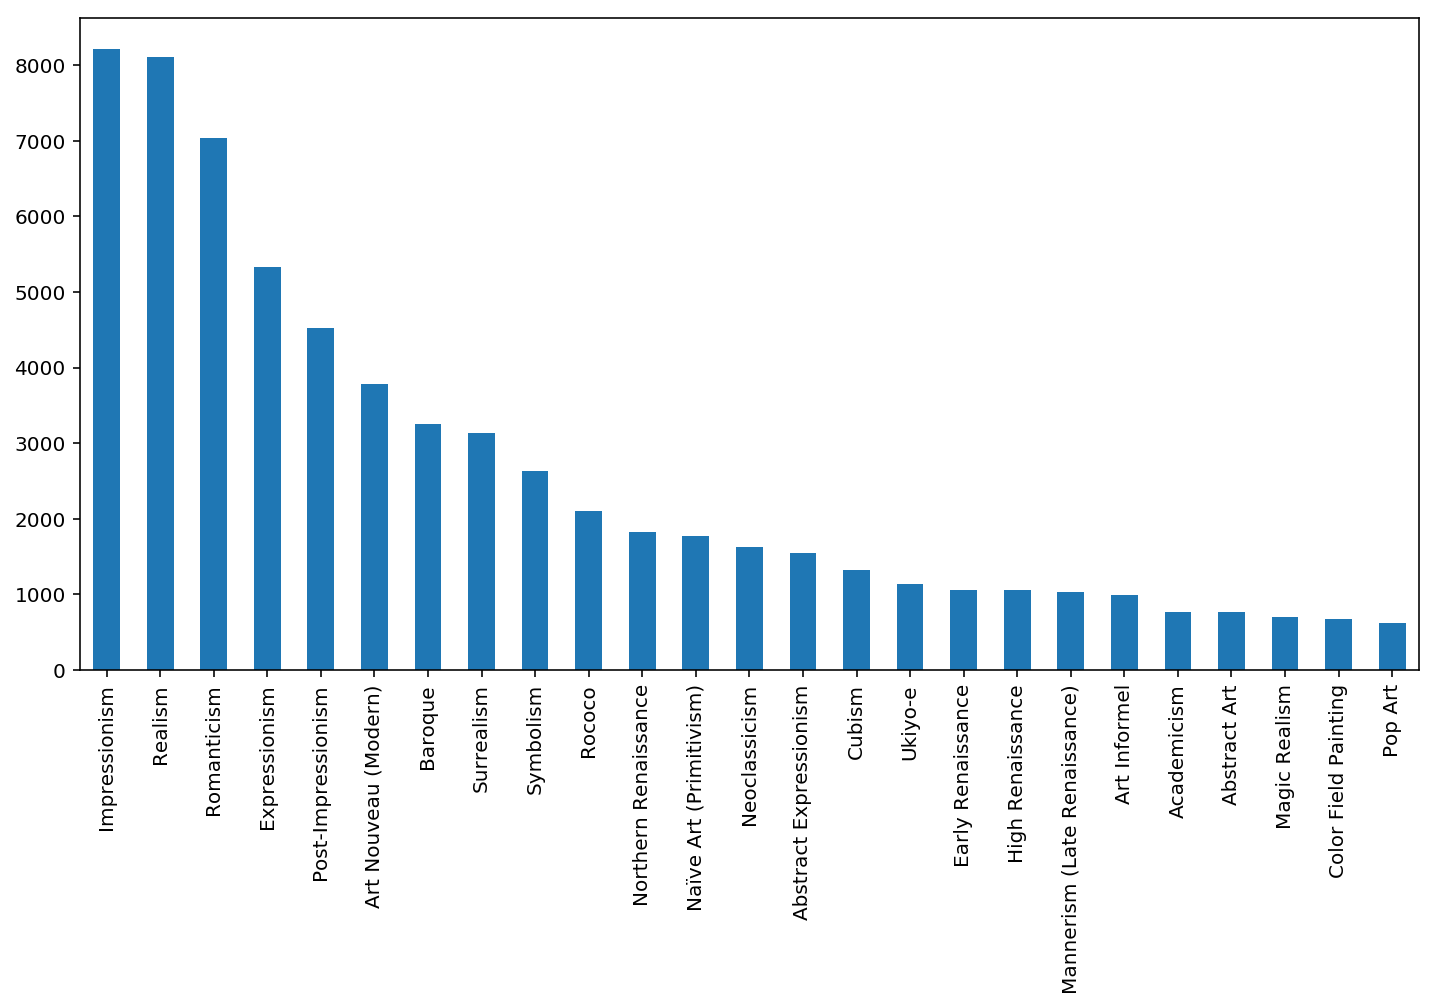

In [69]:
plt.subplots(figsize=(12, 6))
train_paintings['style'].value_counts()[:25].plot(kind='bar');

## Paintings by Artist

In [14]:
print('Total number of artists:', train_paintings.artist.value_counts().shape[0])

# top 20 painting styles
train_paintings.artist.value_counts()[:20]

Total number of artists: 2074


Paul Cezanne                  412
Giovanni Battista Piranesi    402
Martiros Saryan               399
Ilya Repin                    397
Camille Pissarro              393
Vincent van Gogh              392
Theophile Steinlen            389
Pyotr Konchalovsky            388
Boris Kustodiev               388
Pierre-Auguste Renoir         388
Edgar Degas                   387
Gustave Dore                  387
Eugene Boudin                 387
Camille Corot                 387
Henri Matisse                 384
Albrecht Durer                383
Claude Monet                  383
Ivan Aivazovsky               378
Pablo Picasso                 377
John Singer Sargent           377
Name: artist, dtype: int64

In [ ]:
plt.subplots(figsize=(12, 6))
train_paintings['style'].value_counts()[:20].plot(kind='bar').set_title('Painting Styles');

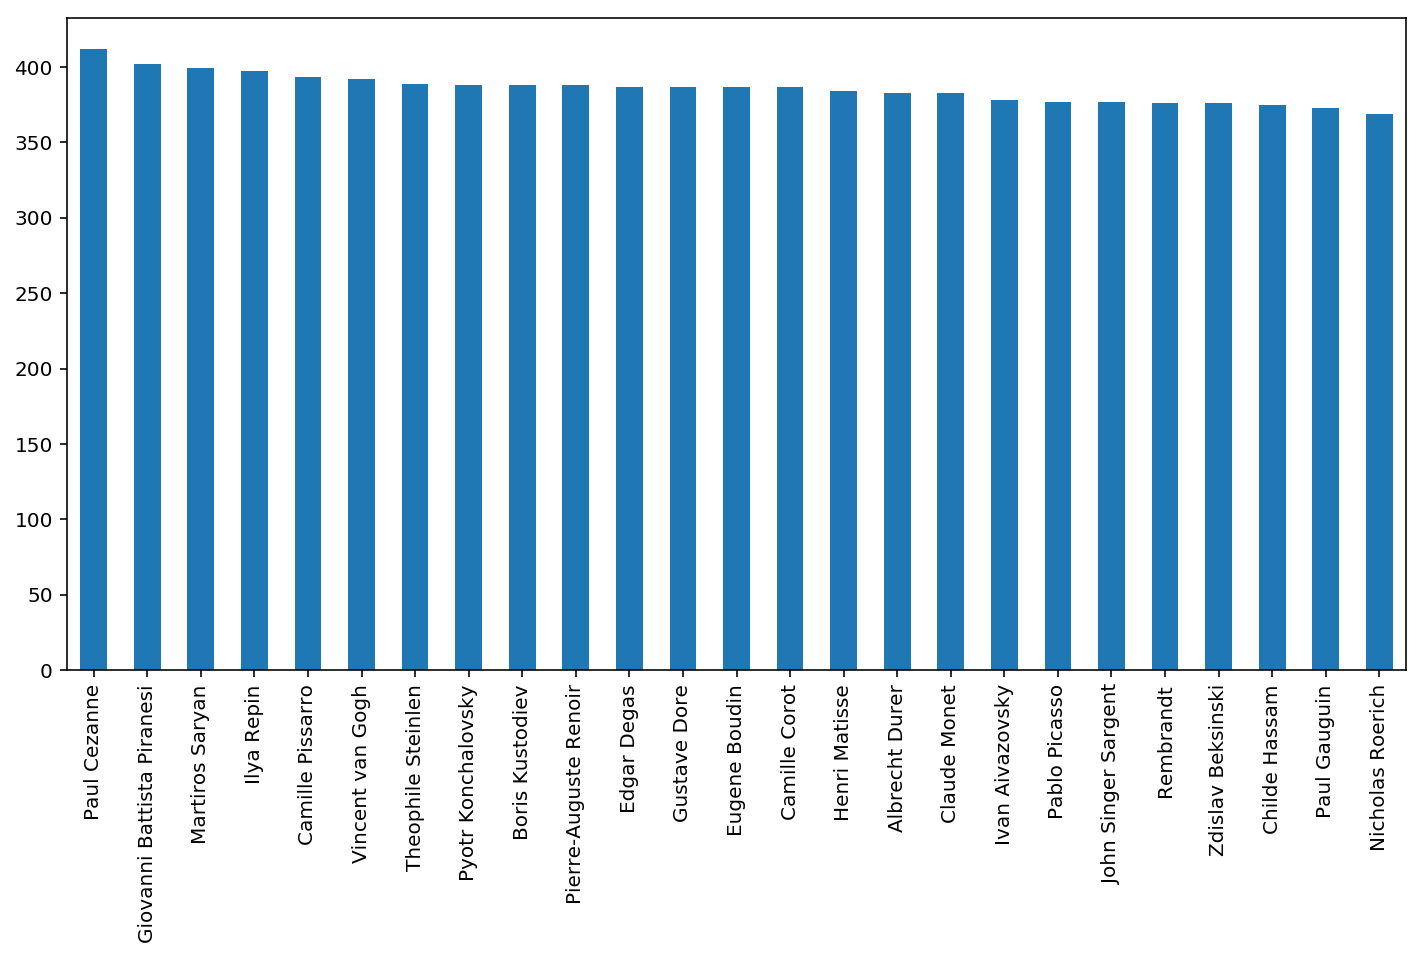

In [70]:
plt.subplots(figsize=(12, 6))
train_paintings.artist.value_counts()[:25].plot(kind='bar');

# Average / multiplication of images as "baseline" model

#### Functions to help with this...
- load images with keras `load_img`
- convert images to numpy arrays with `img_to_array` to manipulate (ie add, multiply, etc)
- use `array_to_img(x, data_format="channels_last")` (converts numpy array back to image)

In [16]:
def create_subset(genre_or_style, name):
    mask = train_paintings[genre_or_style] == name
    return train_paintings[mask]    

def create_array(subset):
    files = subset.new_filename
    return np.array([img_to_array(load_img('../painting_data/kaggle_paint_numbers/resized_72_all/' + fname)) for fname in files])

def display_5_from_array(array):
    for x in array:
        img = array_to_img(x, data_format="channels_last")
        display(img)

## Portraits
### Create portrait subset

In [17]:
portraits = create_subset('genre', 'portrait')
print('shape:', portraits.shape)
portraits.head(2)

shape: (12926, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
72,Mario Tozzi,1976,portrait,4404.0,5333.0,3809347.0,wikiart,NaN,Volto Misterioso,train_and_test,True,99460.jpg
73,Lorenzo Lotto,1547,portrait,5536.0,4226.0,8420464.0,wikiart,High Renaissance,Portrait of Giovanni della Volta with his Wife...,train_and_test,True,5194.jpg


### Create array from portrait images

In [18]:
portrait_array = create_array(portraits)
portrait_array.shape

(12926, 72, 72, 3)

### Display first 5 portrait paintings & average

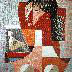

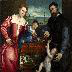

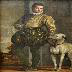

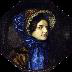

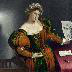

In [19]:
display_5_from_array(portrait_array[:5])

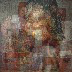

In [20]:
portrait_5_mean = np.mean(portrait_array[:5], axis=0)
portrait_5_mean_display = array_to_img(portrait_5_mean, data_format="channels_last")
display(portrait_5_mean_display)

### Average ALL portrait images for composite

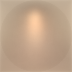

In [21]:
portrait_mean = np.mean(portrait_array, axis=0)
portrait_display = array_to_img(portrait_mean, data_format="channels_last")
display(portrait_display)

## Landscapes
### Create landscape subset

In [22]:
landscapes = create_subset('genre', 'landscape')
print('shape:', landscapes.shape)
landscapes.head(2)

shape: (11548, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
11,Wolfgang Paalen,1937.0,landscape,5331.0,8351.0,1407667.0,wikiart,Surrealism,Forbidden Land,train_only,True,70944.jpg
13,Utagawa Kunisada,NaN,landscape,9293.0,4688.0,10274760.0,wikiart,Ukiyo-e,Snowy landscape with a woman brandishing a bro...,train_only,True,48138.jpg


### Create array from landscape images

In [23]:
landscape_array = create_array(landscapes)
landscape_array.shape

(11548, 72, 72, 3)

### Display first 5 landscape paintings & average

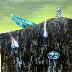

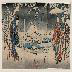

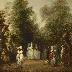

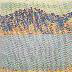

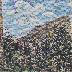

In [24]:
display_5_from_array(landscape_array[:5])

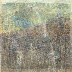

In [25]:
landscape_5_mean = np.mean(landscape_array[:5], axis=0)
landscape_5_mean_display = array_to_img(landscape_5_mean, data_format="channels_last")
display(landscape_5_mean_display)

### Average ALL landscape images for composite

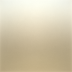

In [26]:
landscape_mean = np.mean(landscape_array, axis=0)
landscape_display = array_to_img(landscape_mean, data_format="channels_last")
display(landscape_display)

## Impressionism style
### Create Impressionism subset

In [27]:
impressionism = create_subset('style', 'Impressionism')
print('shape:', impressionism.shape)
impressionism.head(2)

shape: (8220, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
147,Edgar Degas,1869,interior,5382.0,3349.0,1824204.0,wikiart,Impressionism,Interior (The Rape),train_and_test,True,95360.jpg
216,Claude Monet,1883,landscape,4540.0,3611.0,4873803.0,wikiart,Impressionism,"The Manneport, Rock Arch West of Etretat",train_and_test,True,49757.jpg


### Create array from Impressionism images

In [28]:
impressionism_array = create_array(impressionism)
impressionism_array.shape

(8220, 72, 72, 3)

### Display first 5 Impressionism paintings & average

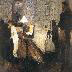

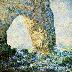

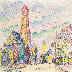

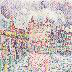

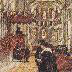

In [29]:
display_5_from_array(impressionism_array[:5])

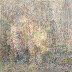

In [30]:
impressionism_5_mean = np.mean(impressionism_array[:5], axis=0)
impressionism_5_mean_display = array_to_img(impressionism_5_mean, data_format="channels_last")
display(impressionism_5_mean_display)

### Average ALL Impressionism images for composite

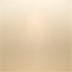

In [31]:
impressionism_mean = np.mean(impressionism_array, axis=0)
impressionism_display = array_to_img(impressionism_mean, data_format="channels_last")
display(impressionism_display)

## Artist
### Create Cezanne subset

In [32]:
cezanne = create_subset('artist', 'Paul Cezanne')
print('shape:', cezanne.shape)
cezanne.head(2)

shape: (412, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
1005,Paul Cezanne,c.1906,portrait,2536.0,3725.0,919573.0,wikiart,Post-Impressionism,The Sailor,train_and_test,True,2165.jpg
1012,Paul Cezanne,1870,portrait,3176.0,2964.0,713766.0,wikiart,Romanticism,Paul Alexis Reading at Zola's House,train_and_test,True,30259.jpg


### Create array from Cezanne images

In [33]:
cezanne_array = create_array(cezanne)
cezanne_array.shape

(412, 72, 72, 3)

### Display first 5 Cezanne paintings & average

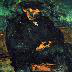

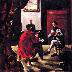

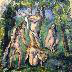

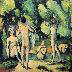

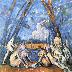

In [34]:
display_5_from_array(cezanne_array[:5])

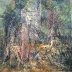

In [35]:
cezanne_5_mean = np.mean(cezanne_array[:5], axis=0)
cezanne_5_mean_display = array_to_img(cezanne_5_mean, data_format="channels_last")
display(cezanne_5_mean_display)

### Average ALL Cezanne images for composite

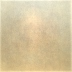

In [36]:
cezanne_mean = np.mean(cezanne_array, axis=0)
cezanne_display = array_to_img(cezanne_mean, data_format="channels_last")
display(cezanne_display)

### Create Van Gogh subset

In [37]:
vangogh = create_subset('artist', 'Vincent van Gogh')
print('shape:', vangogh.shape)
vangogh.head(2)

shape: (392, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
1079,Vincent van Gogh,1887,cityscape,2630.0,3461.0,9630782.0,wikiart,Post-Impressionism,Entrance to the Moulin de la Galette,train_and_test,True,75309.jpg
1113,Vincent van Gogh,1886,self-portrait,2725.0,3301.0,9226662.0,wikiart,Post-Impressionism,Self-Portrait with Dark Felt Hat at the Easel,train_and_test,True,21520.jpg


### Create array from Van Gogh images

In [38]:
vangogh_array = create_array(vangogh)
vangogh_array.shape

(392, 72, 72, 3)

### Display first 5 Van Gogh paintings & average

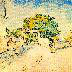

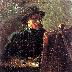

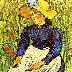

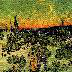

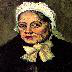

In [39]:
display_5_from_array(vangogh_array[:5])

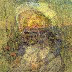

In [40]:
vangogh_5_mean = np.mean(vangogh_array[:5], axis=0)
vangogh_5_mean_display = array_to_img(vangogh_5_mean, data_format="channels_last")
display(vangogh_5_mean_display)

### Average ALL Van Gogh images for composite

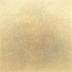

In [41]:
vangogh_mean = np.mean(vangogh_array, axis=0)
vangogh_display = array_to_img(vangogh_mean, data_format="channels_last")
display(vangogh_display)

## Random Forest Classifier
### Subset data to paintings from only Cezanne and Van Gogh

In [42]:
cezanne_vangogh_train = train_paintings[(train_paintings.artist == 'Vincent van Gogh') | (train_paintings.artist == 'Paul Cezanne')]
print(cezanne_vangogh_train.shape)
cezanne_vangogh_train.head()

(804, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
1005,Paul Cezanne,c.1906,portrait,2536.0,3725.0,919573.0,wikiart,Post-Impressionism,The Sailor,train_and_test,True,2165.jpg
1012,Paul Cezanne,1870,portrait,3176.0,2964.0,713766.0,wikiart,Romanticism,Paul Alexis Reading at Zola's House,train_and_test,True,30259.jpg
1027,Paul Cezanne,1880,genre painting,3176.0,2939.0,1338046.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,True,46247.jpg
1066,Paul Cezanne,1880,genre painting,3176.0,2874.0,1146603.0,wikiart,Post-Impressionism,Bathers,train_and_test,True,63504.jpg
1079,Vincent van Gogh,1887,cityscape,2630.0,3461.0,9630782.0,wikiart,Post-Impressionism,Entrance to the Moulin de la Galette,train_and_test,True,75309.jpg


In [43]:
cezanne_vangogh_test = test_paintings[(test_paintings.artist == 'Vincent van Gogh') | (test_paintings.artist == 'Paul Cezanne')]
print(cezanne_vangogh_test.shape)
cezanne_vangogh_test.head()

(189, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
1357,Paul Cezanne,1878,genre painting,3176.0,2618.0,1139110.0,wikiart,Post-Impressionism,Four Bathers,train_and_test,False,19446.jpg
1377,Paul Cezanne,1894,still life,3176.0,2606.0,737724.0,wikiart,Post-Impressionism,"Curtain, Jug and Fruit",train_and_test,False,94593.jpg
1393,Paul Cezanne,1877,symbolic painting,3176.0,2600.0,958500.0,wikiart,Impressionism,The Eternal Woman,train_and_test,False,64480.jpg
1475,Paul Cezanne,c.1905,landscape,3176.0,2552.0,836544.0,wikiart,Cubism,Montagne Sainte-Victoire and the Black Chateau,train_and_test,False,71902.jpg
1478,Paul Cezanne,c.1890,landscape,3176.0,2551.0,811453.0,wikiart,Post-Impressionism,Mont Sainte-Victoire,train_and_test,False,11113.jpg


### Cast data to numpy arrays for classifier

In [44]:
cezanne_vangogh_train_files = cezanne_vangogh_train.new_filename
cezanne_vangogh_train_array = np.array([img_to_array(load_img('../painting_data/kaggle_paint_numbers/resized_72_all/' + fname)).flatten() for fname in cezanne_vangogh_train_files])
cezanne_vangogh_train_array.shape

(804, 15552)

In [45]:
y_train = cezanne_vangogh_train.artist
y_train = cezanne_vangogh_train.artist.apply(lambda x: 1 if x == 'Paul Cezanne' else 0)
y_train = np.array(y_train)
y_train.shape

(804,)

In [46]:
cezanne_vangogh_test_files = cezanne_vangogh_test.new_filename
cezanne_vangogh_test_array = np.array([img_to_array(load_img('../painting_data/kaggle_paint_numbers/resized_72_all/' + fname)).flatten() for fname in cezanne_vangogh_test_files])
cezanne_vangogh_test_array.shape

(189, 15552)

In [47]:
y_test = cezanne_vangogh_test.artist
y_test = cezanne_vangogh_test.artist.apply(lambda x: 1 if x == 'Paul Cezanne' else 0)
y_test = np.array(y_test)
y_test.shape

(189,)

In [48]:
# X_train, X_test, y_train, y_test = train_test_split(cezanne_vangogh_array, y, test_size=.25)

In [49]:
X_train = cezanne_vangogh_train_array
X_test = cezanne_vangogh_test_array

### Train Simple Random Forest Classifier

In [72]:
forest.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>

In [50]:
forest = RandomForestClassifier() 
forest = forest.fit(X_train, y_train)

In [51]:
pred_labels = forest.predict(X_test)
predict_probs = forest.predict_proba(X_test)
predict_probs = np.max(predict_probs, axis=1)

### Generalized Performance

In [52]:
print('accuracy:', forest.score(X_test, y_test))
print('-----------------------------------------------------')
print(metrics.classification_report(y_test, pred_labels))

accuracy: 0.650793650794
-----------------------------------------------------
             precision    recall  f1-score   support

          0       0.66      0.75      0.70       102
          1       0.64      0.54      0.59        87

avg / total       0.65      0.65      0.65       189



### Error Analysis
To better understand feature learning.

In [53]:
results = pd.DataFrame(data={'actual_label': y_test, 'predicted_label': pred_labels, 'predicted_probability': predict_probs})
results['predicted_artist'] = results.predicted_label.apply(lambda x: 'Paul Cezanne' if x == 1 else 'Vincent van Gogh')
results['true_artist'] = results.actual_label.apply(lambda x: 'Paul Cezanne' if x == 1 else 'Vincent van Gogh')
results.head()

,actual_label,predicted_label,predicted_probability,predicted_artist,true_artist
0,1,1,0.6,Paul Cezanne,Paul Cezanne
1,1,1,0.6,Paul Cezanne,Paul Cezanne
2,1,0,0.6,Vincent van Gogh,Paul Cezanne
3,1,1,0.8,Paul Cezanne,Paul Cezanne
4,1,1,0.7,Paul Cezanne,Paul Cezanne


In [54]:
correct_mask = results.predicted_label == results.actual_label
correct = results[correct_mask]
top_correct = correct.sort_values(['predicted_probability'], ascending=False)[:5]
top_correct_idx = top_correct.index.values
top_correct_idx_list = top_correct_idx.tolist()

In [55]:
incorrect_mask = results.predicted_label != results.actual_label
incorrect = results[incorrect_mask]
top_incorrect = incorrect.sort_values(['predicted_probability'], ascending=False)[:5]
top_incorrect_idx = top_incorrect.index.values
top_incorrect_idx_list = top_incorrect_idx.tolist()

In [56]:
uncertain_mask = (results.predicted_probability.between(0.490, 0.510)) & (results.predicted_label != results.actual_label)
most_uncertain = results[uncertain_mask]
top_most_uncertain = most_uncertain.sort_values(['predicted_probability'], ascending=False)[:5]
top_most_uncertain_idx = top_most_uncertain.index.values
top_most_uncertain_idx_list = top_most_uncertain_idx.tolist()

In [57]:
def error_analysis(confidence):
    for i in confidence:
        x = X_test[i]
        x_reshape = x.reshape([72, 72, 3])
        x_display = array_to_img(x_reshape, data_format="channels_last")
        display(x_display)
        print("Prediction: {0} (probability: {1:.2f})\nTrue Label: {2}".format(results['predicted_artist'][i], 
                                                                               results['predicted_probability'][i], results['true_artist'][i]))
        print('------------------------------------------------')

#### Test examples model found very easy to classify:

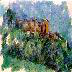

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


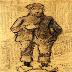

Prediction: Vincent van Gogh (probability: 1.00)
True Label: Vincent van Gogh
------------------------------------------------


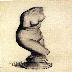

Prediction: Vincent van Gogh (probability: 1.00)
True Label: Vincent van Gogh
------------------------------------------------


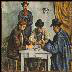

Prediction: Paul Cezanne (probability: 1.00)
True Label: Paul Cezanne
------------------------------------------------


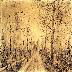

Prediction: Vincent van Gogh (probability: 1.00)
True Label: Vincent van Gogh
------------------------------------------------


In [58]:
error_analysis(top_correct_idx_list)

#### Test examples model was badly fooled by:

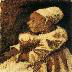

Prediction: Paul Cezanne (probability: 1.00)
True Label: Vincent van Gogh
------------------------------------------------


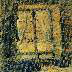

Prediction: Paul Cezanne (probability: 0.90)
True Label: Vincent van Gogh
------------------------------------------------


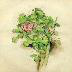

Prediction: Vincent van Gogh (probability: 0.90)
True Label: Paul Cezanne
------------------------------------------------


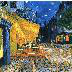

Prediction: Paul Cezanne (probability: 0.90)
True Label: Vincent van Gogh
------------------------------------------------


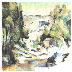

Prediction: Vincent van Gogh (probability: 0.80)
True Label: Paul Cezanne
------------------------------------------------


In [59]:
error_analysis(top_incorrect_idx_list)

#### Test examples model is the most uncertain about:

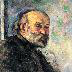

Prediction: Vincent van Gogh (probability: 0.50)
True Label: Paul Cezanne
------------------------------------------------


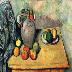

Prediction: Vincent van Gogh (probability: 0.50)
True Label: Paul Cezanne
------------------------------------------------


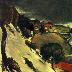

Prediction: Vincent van Gogh (probability: 0.50)
True Label: Paul Cezanne
------------------------------------------------


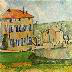

Prediction: Vincent van Gogh (probability: 0.50)
True Label: Paul Cezanne
------------------------------------------------


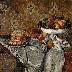

Prediction: Vincent van Gogh (probability: 0.50)
True Label: Paul Cezanne
------------------------------------------------


In [60]:
error_analysis(top_most_uncertain_idx_list)

#### Model tends to over-predict Vincent van Gogh

In [61]:
incorrect.predicted_artist.value_counts()

Vincent van Gogh    40
Paul Cezanne        26
Name: predicted_artist, dtype: int64

### Return feature importances 
To understand important pixel positions.

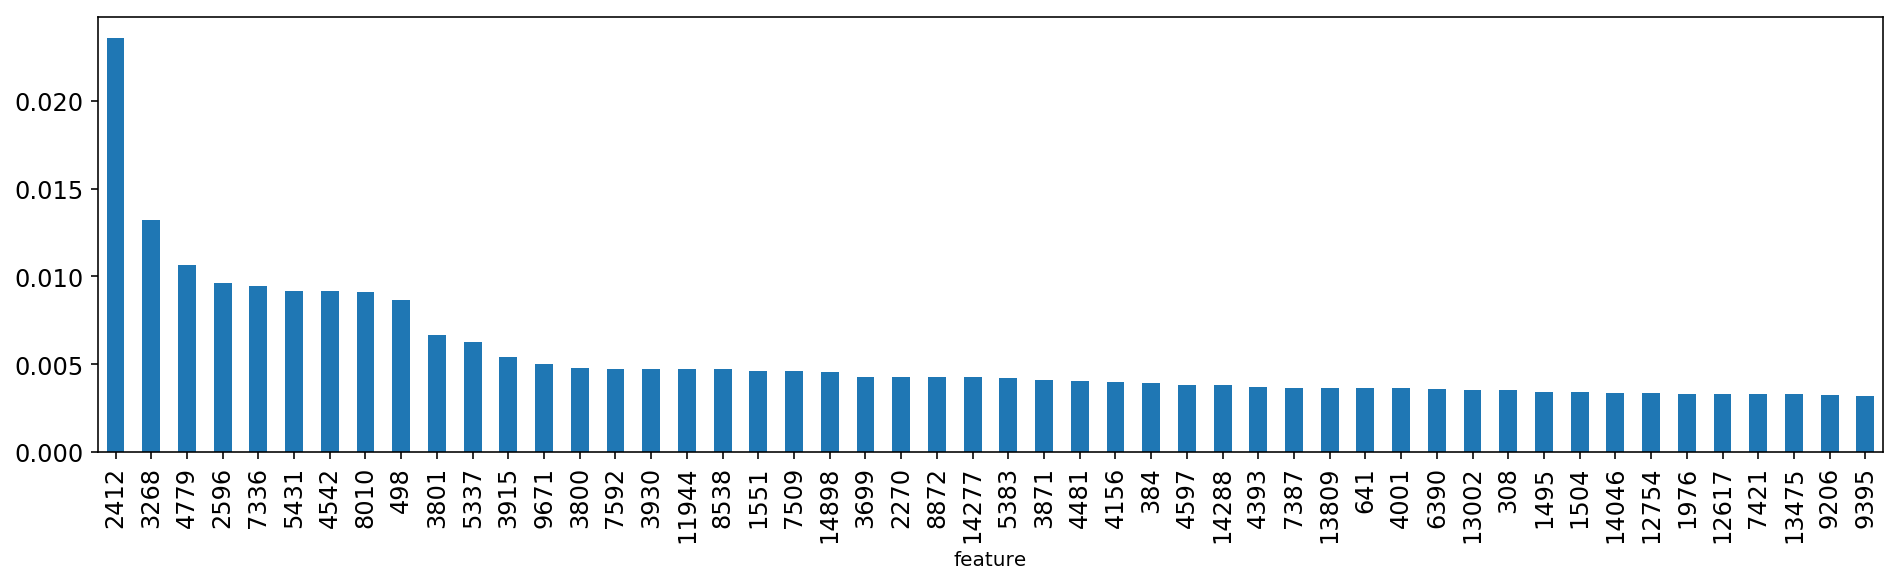

In [62]:
feature_importance = pd.DataFrame({
    'feature': list(range(15552)),
    'importance': forest.feature_importances_})

important_pixels = feature_importance.sort_values('importance', ascending=False)

important_pixels[:50].plot.bar(x="feature", legend=None, figsize=(16, 4), \
                            fontsize=12);